In [2]:
from torch.distributions.beta import Beta
from mutect3 import tensors, train, networks, data
from mutect3 import normal_artifact as na
import torch.utils.data

%matplotlib inline

In [8]:
# load table files produced by GATK, parse and generate data, and pickle data
PICKLE_DIR = '/Users/davidben/mutect3/pickles/'
TABLE_DIR = '/Users/davidben/mutect3/tables/'


DREAMS = ['dream1', 'dream2' , 'dream3', 'dream4']
tumor_samples = ['synthetic.challenge.set1.tumor','background.synth.challenge2.snvs.svs.tumorbackground','IS3.snv.indel.sv','synthetic.challenge.set4.tumour']
normal_samples = ['synthetic.challenge.set1.normal','synthetic.challenge.set2.normal','G15512.prenormal.sorted','synthetic.challenge.set4.normal']

DREAM_1_PAIR, DREAM_2_PAIR, DREAM_3_PAIR, DREAM_4_PAIR = (PICKLE_DIR + dream + '-pair-train.pickle' for dream in DREAMS)
DREAM_1_TEST, DREAM_2_TEST, DREAM_3_TEST, DREAM_4_TEST = (PICKLE_DIR + dream + '-test.pickle' for dream in DREAMS)

DREAM_1_NA, DREAM_2_NA, DREAM_3_NA, DREAM_4_NA = (PICKLE_DIR + dream + '-normal-artifact.pickle' for dream in DREAMS)
DREAM_1_SMALL_NA, DREAM_2_SMALL_NA, DREAM_3_SMALL_NA, DREAM_4_SMALL_NA = (PICKLE_DIR + dream + '-small-normal-artifact.pickle' for dream in DREAMS)

# just dream 1 for speed
#DREAMS = ['dream1']
#tumor_samples = ['synthetic.challenge.set1.tumor']
#normal_samples = ['synthetic.challenge.set1.normal']

DREAM_1_SMALL_PAIR = PICKLE_DIR + 'dream1-small-pair-train.pickle'
DREAM_1_SMALL_TEST = PICKLE_DIR + 'dream1-small-test.pickle'

#NA_TABLE = NORMAL_ARTIFACT_DIR + 'small-normal-artifact.table'
#NA_PICKLE = NORMAL_ARTIFACT_DIR + 'small-normal-artifact.pickle'

GENERATE_PICKLES = False
if GENERATE_PICKLES:
    for dream, tumor_sample, normal_sample in zip(DREAMS, tumor_samples, normal_samples):
        print("Generating tensors for " + dream)
        tumor_table, normal_table = (TABLE_DIR + dream + suffix for suffix in ('-tumor.table', '-normal.table'))
        tensors.generate_pickles(tumor_table, normal_table, tumor_sample, normal_sample, PICKLE_DIR, dream)  
        
        na_table = TABLE_DIR + dream + '-small-normal-artifact.table'
        na_pickle = PICKLE_DIR + dream + '-small-normal-artifact.pickle'
        na.generate_normal_artifact_pickle(na_table, na_pickle)

Loading normal artifact dataset from pickled files
Training normal artifact model


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Loading datasets from pickled files
Unlabeled data: 19577, labeled data: 18968
Dataset sizes -- training: 34690, validation: 3855, test: 2018
Training data includes 6 PASS variants labelled as artifacts.


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

AF spectra epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Optimal logit threshold: 0.005981520749628544


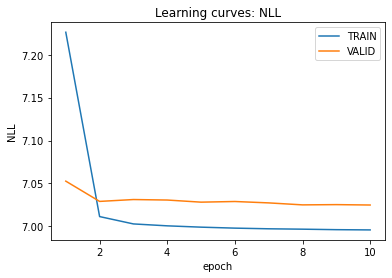

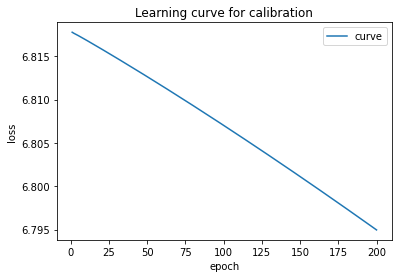

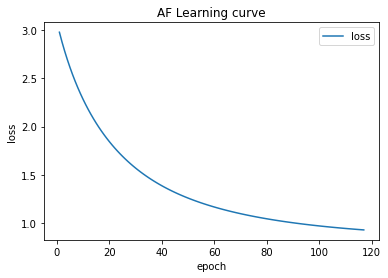

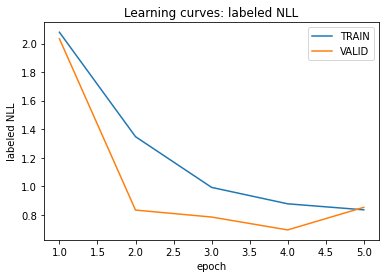

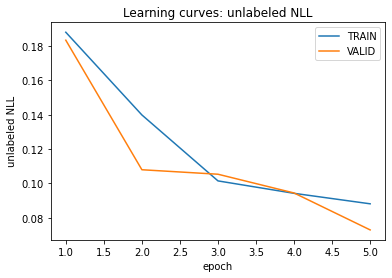

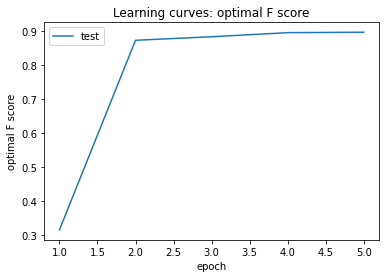

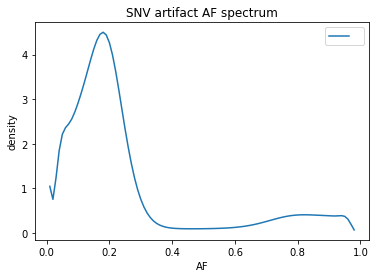

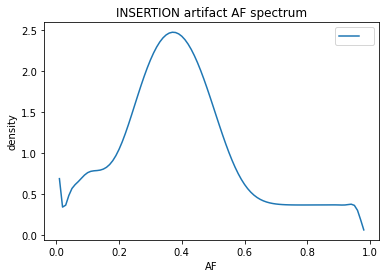

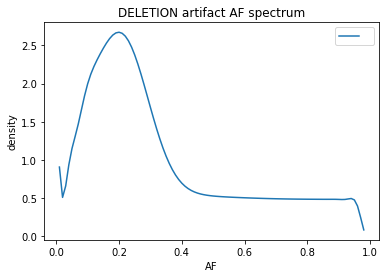

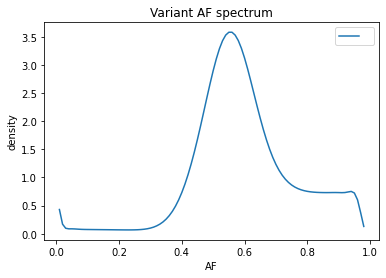

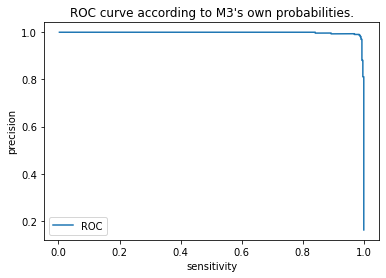

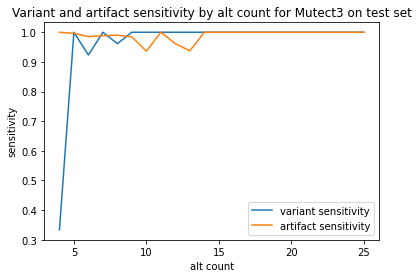

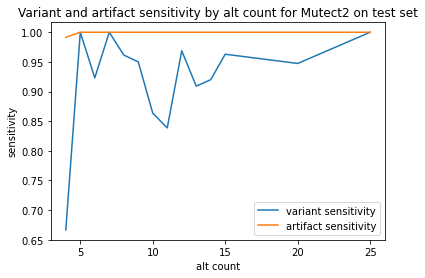

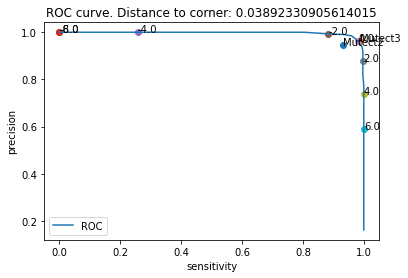

In [9]:
beta1 = Beta(5,1)
beta2 = Beta(5,1)
batch_size = 64
num_epochs = 5
params = train.TrainingParameters(batch_size, num_epochs, beta1, beta2)

hidden_read_layers = [20,20]
hidden_info_layers = [20,20]
aggregation_layers = [20]
output_layers = [10]
dropout_p = 0.2
m3_params = networks.Mutect3Parameters(hidden_read_layers, hidden_info_layers, aggregation_layers, output_layers, dropout_p)

trained_model = train.run_evaluation([DREAM_1_SMALL_PAIR], DREAM_1_SMALL_TEST, DREAM_1_SMALL_NA, params, m3_params)

In [5]:
training_pickles, test_pickle = [DREAM_1_SMALL_PAIR], DREAM_1_SMALL_TEST
train, valid, test = data.make_datasets(training_pickles, test_pickle)

Unlabeled data: 4423, labeled data: 8084
Dataset sizes -- training: 11256, validation: 1251, test: 1764


In [13]:
test[1].normal_depth() - test[1].normal_alt_count(), len(test[1].ref_tensor())

(108, 10)

Loading normal artifact dataset from pickled files
Training normal artifact model



Loading datasets from pickled files
Unlabeled data: 44457, labeled data: 80619
Dataset sizes -- training: 112568, validation: 12508, test: 17649
Training data includes 18 PASS variants labelled as artifacts.



Optimal logit threshold: 0.08844363689422607


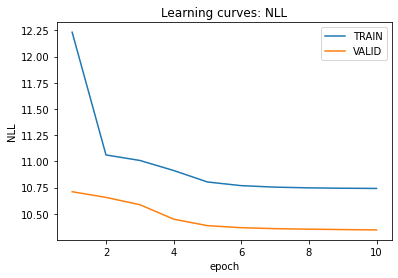

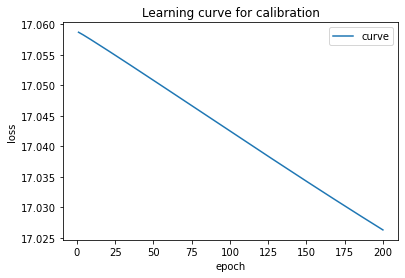

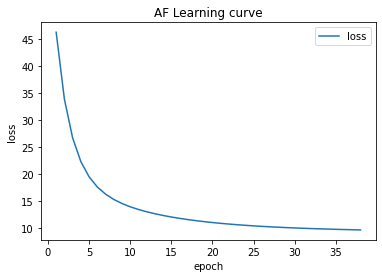

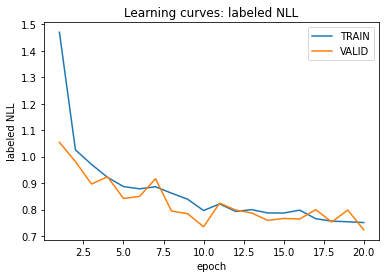

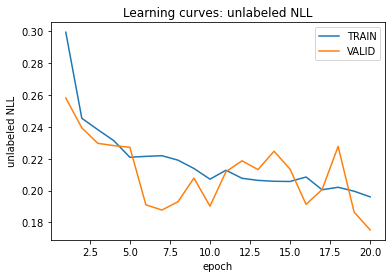

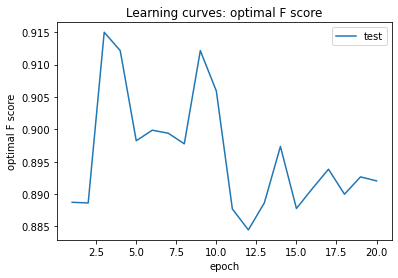

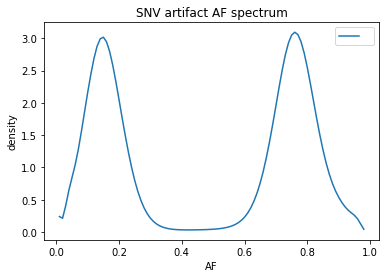

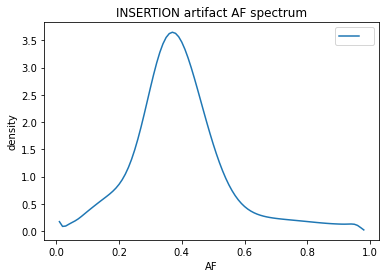

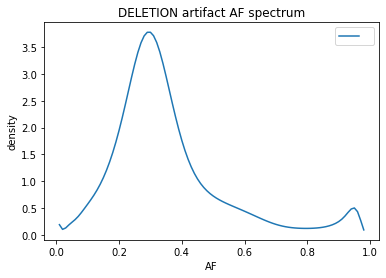

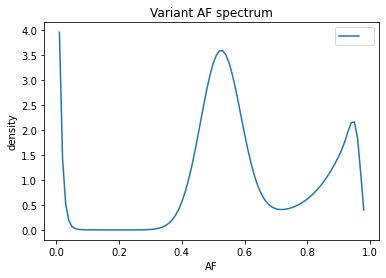

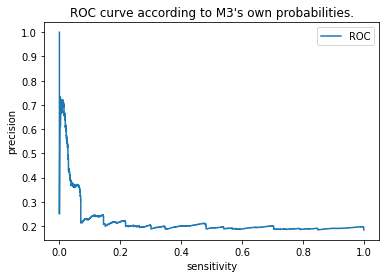

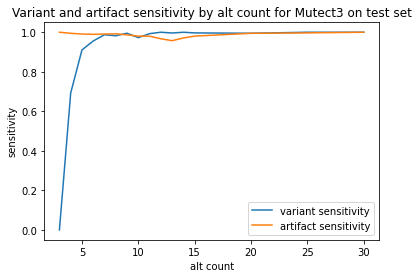

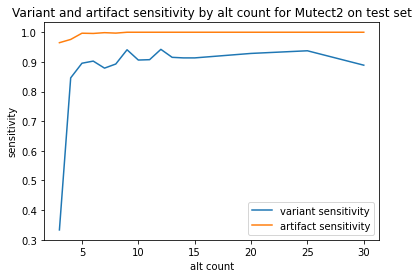

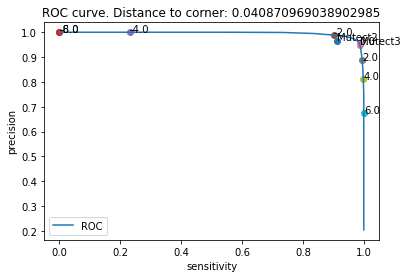

In [3]:
beta1 = Beta(5,1)
beta2 = Beta(5,1)
batch_size = 64
num_epochs = 20
params = train.TrainingParameters(batch_size, num_epochs, beta1, beta2)

hidden_read_layers = [30,30,30,30]
hidden_info_layers = [20,20,20]
aggregation_layers = [20,20]
output_layers = [10]
dropout_p = 0.2
m3_params = networks.Mutect3Parameters(hidden_read_layers, hidden_info_layers, aggregation_layers, output_layers, dropout_p)
trained_model = train.run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, NA_PICKLE, params, m3_params)

In [16]:
alpha, beta = na_model.get_beta_parameters(batch)
shapes = torch.stack((alpha, beta), dim=1)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9e53da3be0>)

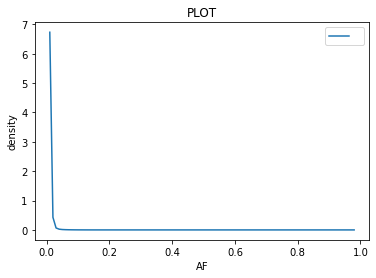

In [15]:
datum = na.NormalArtifactDatum(normal_alt_count=0, normal_depth=50, tumor_alt_count=10, tumor_depth=20, downsampling=1.0, variant_type="SNV")
na_model.plot_spectrum(datum, "PLOT")

In [41]:
snv_normal_af = []
snv_tumor_af = []
indel_normal_af = []
indel_tumor_af = []
for datum in na_train:
    if datum.variant_type() == "SNV":
        snv_normal_af.append(datum.normal_alt_count()/(datum.normal_depth()+0.01))
        snv_tumor_af.append(datum.tumor_alt_count()/(datum.tumor_depth()+0.01))
    else:
        indel_normal_af.append(datum.normal_alt_count()/(datum.normal_depth()+0.01))
        indel_tumor_af.append(datum.tumor_alt_count()/(datum.tumor_depth()+0.01))

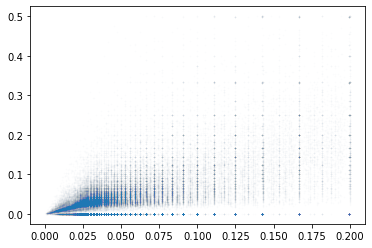

In [42]:
import matplotlib.pyplot as plt
plt.scatter(torch.tensor(snv_normal_af), torch.tensor(snv_tumor_af), s=0.5,alpha=0.01)

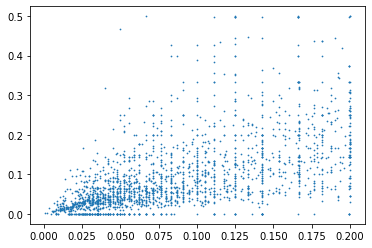

In [43]:
plt.scatter(torch.tensor(indel_normal_af), torch.tensor(indel_tumor_af), s=0.5,alpha=1.0)

ValueError: only one element tensors can be converted to Python scalars

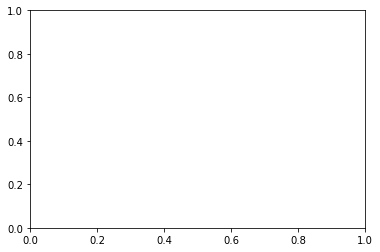

In [37]:
x=torch.tensor(normal_af)
y=torch.tensor(tumor_af)
plt.hist2d(x, y)